**Definition of Offer Response Classes:**

- 0 - user did not make any purchase due to sent offers
- 1 - user completed offer due to sent offer
- 2 - user completed offer by chance (without viewing)
- 3 - user made purchase due to information

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [3]:
X_df = pd.read_csv("data/processed/data.csv")
y_df = pd.read_csv("data/processed/target.csv")
del X_df["Unnamed: 0"]
del y_df["Unnamed: 0"]

In [4]:
X_df.head()

,user_id,offer_id,completion_time,reward,duration,difficulty,gender_F,gender_M,gender_O,age,income,became_member_year,total_amt
0,13,3,0,0,96,0,0,1,0,58,51000.0,2017,0.87
1,23,3,0,0,96,0,1,0,0,78,71000.0,2017,18.98
2,49,8,0,0,72,0,0,1,0,39,51000.0,2014,1.63
3,67,8,18,0,72,0,0,1,0,75,52000.0,2015,6.86
4,83,8,0,0,72,0,0,1,0,27,35000.0,2018,3.62


In [5]:
y_df.head()

,offer_response
0,0
1,3
2,0
3,3
4,3


## Data Modelling

We will split the data into train and test before building any machine learning model. Test set will comprise of 20% of data. This will contain new data that the model wouldn't have seen and hence will be used for evaluation model performance.

Machine Learning pipelines are built with StandardScaler and PCA as initial steps.
1. As all of our columns are not in same value range we will use StandardScaler to normalize data.
2. Many columns like gender, age, offer duration, offer type have duplicated data we will use PCA to perform dimensionality reduction.

We are using StandardScaler and PCA inside the pipeline and not on the whole data to avoid any data leakage from test data to train data.

Model performance metrics like precision, recall and overall accuracy will be calculated for all classes in target variable (user response). We will also construct a confusion matrix every time to see how many right and wrong predictions happens across all classes.

As observed in Data_Preprocessing notebook our data is unbalanced and we have very few classes for class 3. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) provides a parameter **_scoring_** which allows us to choose the metrics used for evaluation in validation with different parameters passed. We use "balanced_accuracy" as the metrics here which is average of recall obtained in each class. This is designed for unbalanced datasets, for more info look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score).

Five supervised machine learning models are trained and evaluated here:
1. Logistic Regression
2. Decision Tree
3. Naive Bayes
4. Gradient Boosting
5. KNN

In [6]:
def split_train_test_data(X, Y, test_size=0.2):
    """
    Split data into train and test sets
    
    Args:
      - X: independent variables data
      - Y: dependent/target variable data
      - test_size: ratio of test data size to whole
      
    Return:
      - X_train: independent variables data for training
      - X_test: independent variables data for testing
      - Y_train: target variable data for training
      - Y_test: target variable data for testing
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return (X_train, X_test, Y_train, Y_test)

In [7]:
def build_model(clf, parameters=None, scoring=None):
    """
    Build a pipeline with classifier, add parameters to
    GridSearchCV with pipeline.

    Args:
      - clf: machine learning classifier
      - parameters: dictionary containing parameter
                    that needs to be optimized with GridSearchCV
      - scoring: scoring way used in GridSearchCV
    
    Return:
      - GridSearchCV classifier object
    """
    pipeline = Pipeline([
            ('scaler', StandardScaler(copy=False)),
            ('pca', PCA()),
            ('clf', clf),
        ])
    # define parameters for grid search
    param_grid = {
        'pca__n_components': [8, 10, 12],
    }
    
    if parameters is not None:
        for key in parameters.keys():
            param_grid[key] = parameters[key]
    
    # grid search object
    return GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring=scoring)

## Logistic Regression

In [8]:
# split into test train data
X_train, X_test, Y_train, Y_test =  split_train_test_data(X_df, y_df, test_size=0.2)

In [9]:
# build model using classifier
clf = LogisticRegression(max_iter=15000, tol=0.001)
parameters = {
    'clf__penalty': ['none', 'l2'],
    'clf__class_weight': [None, "balanced"],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters, "balanced_accuracy")
# model.fit(X_train, Y_train.values.ravel())


# load from saved model
modelFile = "models/logistic_regression_1.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__class_weight': 'balanced', 'clf__penalty': 'none', 'pca__n_components': 12}


**GridSearchCV** by default fit the model with best parameters so that we can directly run predict on the model.

In [10]:
def evaluate_model(X_test, Y_test, model):
    """
    Make prediction on test data using trained model and evaluate metrics
    
    Args:
      - X_test: test data input
      - Y_test: True value of target variables
      - model: trained ml model
    """
    # get predictions from model
    y_pred = model.predict(X_test)
    # calculate performance metrics
    print(classification_report(Y_test.values.ravel(), y_pred))
    # calculate confusion matric
    print("Confusion Matrix")
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
    disp.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.83      0.54      0.65      8010
           1       0.66      0.78      0.71      4003
           2       1.00      1.00      1.00      2784
           3       0.31      0.98      0.47       957

    accuracy                           0.71     15754
   macro avg       0.70      0.83      0.71     15754
weighted avg       0.78      0.71      0.72     15754

Confusion Matrix


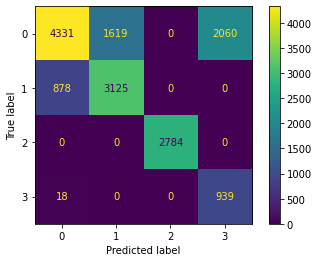

In [11]:
evaluate_model(X_test, Y_test, model)

**Definition of our metrics of interest:**

_What proportion of positive identifications was actually correct?_

> Precision = True_Positive / (True_Positive + False_Positives)

_What proportion of actual positives was identified correctly?_

> Recall = True_Positive / (True_Positive + False_Negatives)

_What proportion predictions are correct?_

> Accuracy = (True_Positive + True_Negative) / (True_Positive + False_Positives + True_Negative + False_Negative)

Although accuracy seems a good metric in this case where we have unbalanced data it is not. Models tend to predict more from the majority class in unbalanced scenarios to gain more accuracy.

The precision and recall scores are better choices to look at in such situations. We have a majority in correct predictions but there are many wrong predictions in class 0 and hence the very low recall score.

In [12]:
def save_model(model, model_filepath):
    """
    Save the trained model to a file as pickle
    Args:
        - model: trained model to save
        - model_filepath: relative path (with filename) to save the model.
    """
    # save the model to disk
    pickle.dump(model, open(model_filepath, 'wb'))

In [13]:
save_model(model, modelFile)

## SMOTE for over sampling

**Synthetic Minority Oversampling Technique (SMOTE)** works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

[source](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [14]:
# perform over_sampling with SMOTE
oversample = SMOTE()

print("Old data rows: ", X_df.shape[0])
X, Y = oversample.fit_resample(X_df, y_df)
print("New data rows:", X.shape[0])

Old data rows:  78770
New data rows: 158984


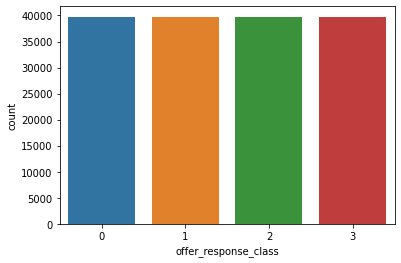

In [15]:
import seaborn as sns

response_counts = Y.offer_response.value_counts().reset_index()
ax = sns.barplot(x='index', y='offer_response', data=response_counts);
ax.set(xlabel="offer_response_class", ylabel="count");

**SMOTE** over-sampled the data and made equal data samples for all user response classes. One issue this could cause is the noise introduced into data due to over-sampling.

In [16]:
# split into test train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
clf = LogisticRegression(max_iter=15000, tol=0.001)
parameters = {
    'clf__penalty': ['none', 'l2'],
    'clf__class_weight': [None, "balanced"],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/logistic_regression.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__class_weight': None, 'clf__penalty': 'none', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.72      0.74      0.73      7878
           1       0.86      0.76      0.81      7896
           2       0.99      1.00      1.00      8055
           3       0.87      0.94      0.91      7968

    accuracy                           0.86     31797
   macro avg       0.86      0.86      0.86     31797
weighted avg       0.86      0.86      0.86     31797

Confusion Matrix


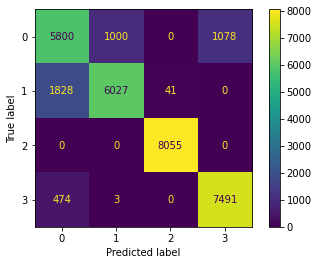

In [18]:
evaluate_model(X_test, Y_test, model)

In [19]:
save_model(model, modelFile)

**Precision**

- class 0: decreased to 0.71 from 0.83
- class 1: increased to 0.86 from 0.66
- class 2: decreased to 0.99 from 1.00
- class 3: increased to 0.87 from 0.31

Although there is a decrease in precision for class 0 we can see a significant increase for other classes.

**Recall**

- class 0: increased to 0.74 from 0.54   
- class 1: decreased to 0.76 from 0.78
- class 2: stayed same to 1.00 from 1.00
- class 3: decreased to 0.94 from 0.98

In Recall there is significant increase in score for class 0 and minor decrease other classes if at all.

**Accuracy**

Accuracy increased significantly from 71% to 86% due to upsampling.

We can still see lot of wrong predictions in class 0, class 1 and class 4, but using smote to upsample the data has helped improve all accuracy, precision and recall significantly across all classes.

The last statement can be supported using the confusion matrices plotted. Before upsampling the severity (purple) for wrongly predicted in class 0 was higher than latter (green).

Let us look at other supervised learning algorithms and their performances.

## Decision Tree

In [20]:
clf = DecisionTreeClassifier()
parameters = {
    'pca__n_components': [12, ],
    'clf__max_depth': [None, 10, 15],
    'clf__max_features': ["auto", "log2"],
}

# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/decision_tree.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__max_depth': None, 'clf__max_features': 'log2', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7878
           1       0.87      0.86      0.86      7896
           2       0.96      0.96      0.96      8055
           3       0.95      0.95      0.95      7968

    accuracy                           0.91     31797
   macro avg       0.91      0.91      0.91     31797
weighted avg       0.91      0.91      0.91     31797

Confusion Matrix


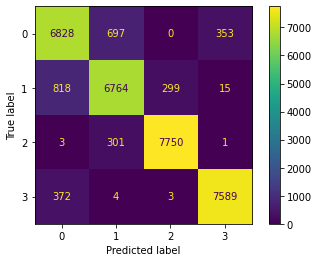

In [21]:
evaluate_model(X_test, Y_test, model)

**Decision Tree** performs much better than logistic regression. The accuracy is 91% with average precision 0.91 and average recall 0.91

In [22]:
save_model(model, modelFile)

## Naive Bayes

In [23]:
clf = GaussianNB()
parameters = {
    'pca__n_components': [12, ],
    'clf__var_smoothing': [0.0001, 0.0000001, 0.000000001],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/naive_bayes.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__var_smoothing': 0.0001, 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.60      0.48      0.53      7878
           1       0.67      0.66      0.67      7896
           2       0.93      0.95      0.94      8055
           3       0.81      0.97      0.88      7968

    accuracy                           0.76     31797
   macro avg       0.75      0.76      0.75     31797
weighted avg       0.75      0.76      0.76     31797

Confusion Matrix


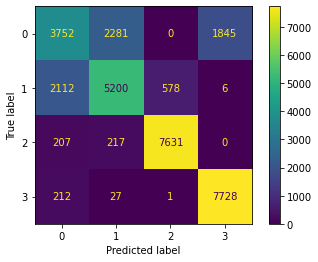

In [24]:
evaluate_model(X_test, Y_test, model)

**Naive Bayes** perform lowest among all classifiers with accuracy 76% and average precision and recall 0.75 and 0.76 respectively.

In [25]:
save_model(model, modelFile)

## Gradient Boosting

In [26]:
clf = GradientBoostingClassifier(tol=0.001)
parameters = {
    'pca__n_components': [12, ],
    'clf__learning_rate': [0.1, 0.01],
    'clf__min_samples_leaf': [5, 10]
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/gradient_boosting.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__learning_rate': 0.1, 'clf__min_samples_leaf': 10, 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.83      0.82      0.83      7878
           1       0.89      0.85      0.87      7896
           2       0.97      1.00      0.98      8055
           3       0.93      0.96      0.94      7968

    accuracy                           0.91     31797
   macro avg       0.91      0.91      0.91     31797
weighted avg       0.91      0.91      0.91     31797

Confusion Matrix


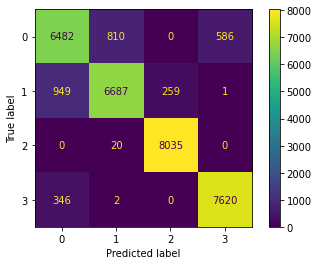

In [27]:
evaluate_model(X_test, Y_test, model)

**Gradient Boosting** classifier gives 91% accuracy and 0.91 average precision and recall.

In [28]:
save_model(model, modelFile)

## KNN

In [29]:
clf = KNeighborsClassifier()
parameters = {
    'pca__n_components': [12, ],
    'clf__n_neighbors': [4, 5, 6],
    'clf__weights': ["uniform", "distance"],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/knn.pkl"
model = pickle.load(open(modelFile, 'rb'))

print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__n_neighbors': 4, 'clf__weights': 'distance', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7878
           1       0.89      0.80      0.84      7896
           2       0.96      0.99      0.98      8055
           3       0.93      0.95      0.94      7968

    accuracy                           0.89     31797
   macro avg       0.89      0.89      0.89     31797
weighted avg       0.89      0.89      0.89     31797

Confusion Matrix


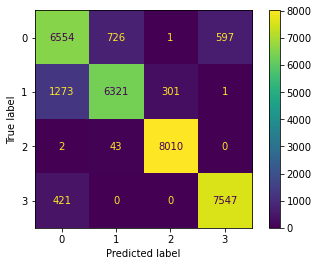

In [30]:
evaluate_model(X_test, Y_test, model)

**K Nearest Neighbour** algorithm also performs well with 89% accuracy and 0.89 average precision and recall.

In [31]:
save_model(model, modelFile)

Among the supervised classifiers evaluated in this project **Decision Tree, Gradient Boosting** and **KNN** perform well with all performance metrics > 88%.

## SMOTE & RandomUnderSampler

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class. [source](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

We will try the Decision Tree Classifier as see if the  performance improves.

In [45]:
from imblearn.pipeline import Pipeline

# perform over-sampling of minority classes
oversample = SMOTE(sampling_strategy='minority', random_state=42)

# perform under-sampling of majority classes
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)

pipeline = Pipeline([
    ('under', under),
    ('over', oversample),
    
])

print("Old data rows: ", X_df.shape[0])
X, Y = pipeline.fit_resample(X_df, y_df)
print("New data rows:", X.shape[0])

Old data rows:  78770
New data rows: 59697


In [46]:
# split into test train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [47]:
clf = DecisionTreeClassifier()
parameters = {
    'pca__n_components': [12, ],
    'clf__max_depth': [None, 10, 15],
    'clf__max_features': ["auto", "log2"],
}

# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/decision_tree_2.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__max_depth': None, 'clf__max_features': 'log2', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4172
           1       0.90      0.90      0.90      4065
           2       0.98      0.99      0.99      2710
           3       0.85      0.84      0.85       993

    accuracy                           0.91     11940
   macro avg       0.91      0.90      0.90     11940
weighted avg       0.91      0.91      0.91     11940

Confusion Matrix


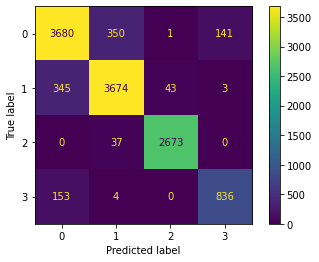

In [50]:
evaluate_model(X_test, Y_test, model)

In [49]:
save_model(model, modelFile)

**SMOTE with RandomUnderSampler** gave same accuracy as only SMOTE but we can see a slight increase in precision and recall for class 0 and class 1.

## Conclusion

In this project we saw that **Decision Tree, Gradient Boosting** and **KNN** algorithms performed well than Naive Bayes and Logistic Regression.

Logistic Regresssion doesn't work well when there is no linear relationship between data and target variables. The algorithm we used to define user response classes surely did not follow a linear relationship. In such cases Decision Tree classifier is known to perform better as is also seen here. [source](https://towardsdatascience.com/when-logistic-regression-simply-doesnt-work-8cd8f2f9d997#:~:text=The%20reason%20is%20that%20the,even%20on%20the%20training%20data)

Naive Bayes has some limitations of its own which could have played a role in its poor performance.
1. It assumes that all feature columns are independent.
2. If there are zero frequency of a class in training data and not in test data, then Naive Bayes cannot make predictions.
Although we tried to eliminate case 2 with over-sampling we might not have ruled out case 1.

**SMOTE with RandomUnderSampler** did not improve the peformance significantly and this could mean the models are unable to learn the patterns for user response classes beyond a point due to high variance. We need to optimize the algorithm for defining user response variable.

## Improvements

There is much scope for improvement in this project. We can explore more parameters in the supervised classifiers that will yield much optimal results. 

The algorithm used to define the criteria can be enhanced for informational offers as we considered an informational offer effective when there is atleast one transaction by user within the required time. There could be another bogo or discount offer sent after a few days to user which might have caused the transaction. The algorithm needs to consider many such edge cases.

We could try other techniques like under sampling, class weights for overcoming the problem of unbalanced data.

The design of the model input restricts us from making predictions for new users and offers, we can build some recommendations using matrix factorizations technique or use other forms of recommendations.